In [1]:
import os, sys
import pandas as pd
import numpy as np
import datetime
from datetime import datetime
import time
import json
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import awswrangler as wr

In [7]:
is_sagemaker_notebook = False
is_clustered_data = True

In [3]:
if is_sagemaker_notebook:
    prefix = "/home/ec2-user/SageMaker"
else:
    prefix = "/Users/Q619505/PycharmProjects/personal-projects/taxi-destination-prediction"

utils_path = os.path.join(f'{prefix}/src/utils/')
pp_path = os.path.join(f'{prefix}/src/preprocessing/')

if utils_path not in sys.path:
    sys.path.append(utils_path)

if pp_path not in sys.path:
    sys.path.append(pp_path)

In [43]:
from utils import *
from data_cleaning import split_lat_lon
from geo_spatial import convert_polyline_to_geojson_format, extract_lat_lon

In [8]:
if is_clustered_data:
    training_file_name = 'train_data_clustered'
    test_file_name = 'test_data_clustered'
else:
    training_file_name = 'train_data'
    test_file_name = 'test_data'

In [10]:
if is_sagemaker_notebook:
    train_data = wr.s3.read_parquet(path=f'{prefix}/data/processed/{training_file_name}.parquet')
    test_data = wr.s3.read_parquet(path=f'{prefix}/data/processed/{test_file_name}.parquet')
else:
    train_data = pd.read_csv(f'{prefix}/data/processed/{training_file_name}.csv', header=0, index_col=False)
    test_data = pd.read_csv(f'{prefix}/data/processed/{test_file_name}.csv', header=0, index_col=False)

In [14]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1366762 entries, 0 to 1366761
Data columns (total 23 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   trip_id                    1366762 non-null  int64  
 1   call_type                  1366762 non-null  object 
 2   origin_call                297184 non-null   float64
 3   origin_stand               687325 non-null   float64
 4   taxi_id                    1366762 non-null  int64  
 5   timestamp                  1366762 non-null  object 
 6   day_type                   1366762 non-null  object 
 7   polyline                   1366762 non-null  object 
 8   n_coordinate_points        1366762 non-null  int64  
 9   total_flight_time_minutes  1366762 non-null  float64
 10  start_point                1366762 non-null  object 
 11  dest_point                 1366762 non-null  object 
 12  final_point                1366762 non-null  object 
 13  total_distan

In [15]:
train_data.groupby('origin_stand', 
                   as_index=False)[['total_flight_time_minutes', 
                'total_distance_km']].agg(['mean', 'median','std','max','min'])

origin_stand total_flight_time_minutes                                 \
                                     mean  median       std    max   min   
0           1.0                  9.313427   8.750  4.040673  20.25  2.25   
1           2.0                  9.362937   8.500  4.498979  20.25  2.25   
2           3.0                  9.276780   8.500  4.084252  20.25  2.25   
3           4.0                  9.824724   9.500  3.911426  20.25  2.25   
4           5.0                  7.871795   8.000  3.075194  17.50  2.50   
..          ...                       ...     ...       ...    ...   ...   
58         59.0                 11.386721  11.250  3.806552  20.25  2.25   
59         60.0                  8.367769   7.750  3.853896  20.25  2.25   
60         61.0                  8.756876   8.000  4.034618  20.25  2.25   
61         62.0                  7.938657   7.000  4.089370  20.25  2.25   
62         63.0                  8.846579   8.125  3.787407  20.25  2.25   

   total_distance_km                                          
                mean    median       std       max       min  
0           2.753333  2.735703  1.349755  6.690235  0.006416  
1           1.894088  1.545281  1.369003  6.682520  0.000000  
2           3.014094  2.547943  1.444284  6.703527  0.003897  
3           2.222699  1.574913  1.454700  6.654618  0.040346  
4           2.973067  2.785920  1.546652  5.966379  0.733402  
..               ...       ...       ...       ...       ...  
58          3.103682  3.079384  1.149470  6.695834  0.002139  
59          2.491828  2.133001  1.503347  6.703502  0.003768  
60          2.424462  2.049524  1.395718  6.701826  0.000754  
61          2.369448  2.022351  1.303812  6.679222  0.004265  
62          2.022935  1.712478  1.141805  6.701119  0.003019  

[63 rows x 11 columns]

In [16]:
train_data.groupby('call_type', 
                   as_index=False)[['total_flight_time_minutes', 
                'total_distance_km']].agg(['mean', 'median','std','max','min'])

call_type total_flight_time_minutes                                \
                                 mean median       std    max   min   
0         A                 10.224592   9.75  4.183504  20.25  2.25   
1         B                  9.390052   9.00  3.973534  20.25  2.25   
2         C                  9.363511   8.75  4.172345  20.25  2.25   

  total_distance_km                                     
               mean    median       std       max  min  
0          2.612523  2.409696  1.460726  6.704244  0.0  
1          2.601098  2.340450  1.406391  6.704126  0.0  
2          2.663418  2.405965  1.551446  6.704493  0.0

In [20]:
train_data = extend_timestamps(train_data, timestamp_column='timestamp')
test_data = extend_timestamps(test_data, timestamp_column='timestamp')

In [22]:
vc_year_month = train_data.year_month.value_counts().sort_index()

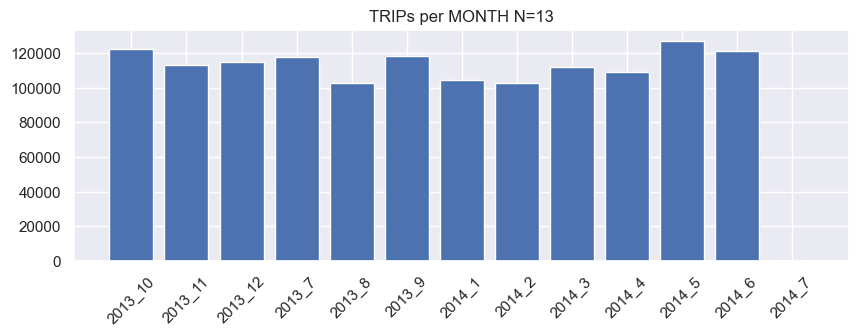

In [23]:
sns.set()
plt.figure(figsize=(10,3))
plt.bar(vc_year_month.index, vc_year_month.values,label='Unique TRIPs per Month')
plt.xticks(vc_year_month.index, rotation=45)
plt.title(f'TRIPs per MONTH N={vc_year_month.shape[0]}')
plt.show()

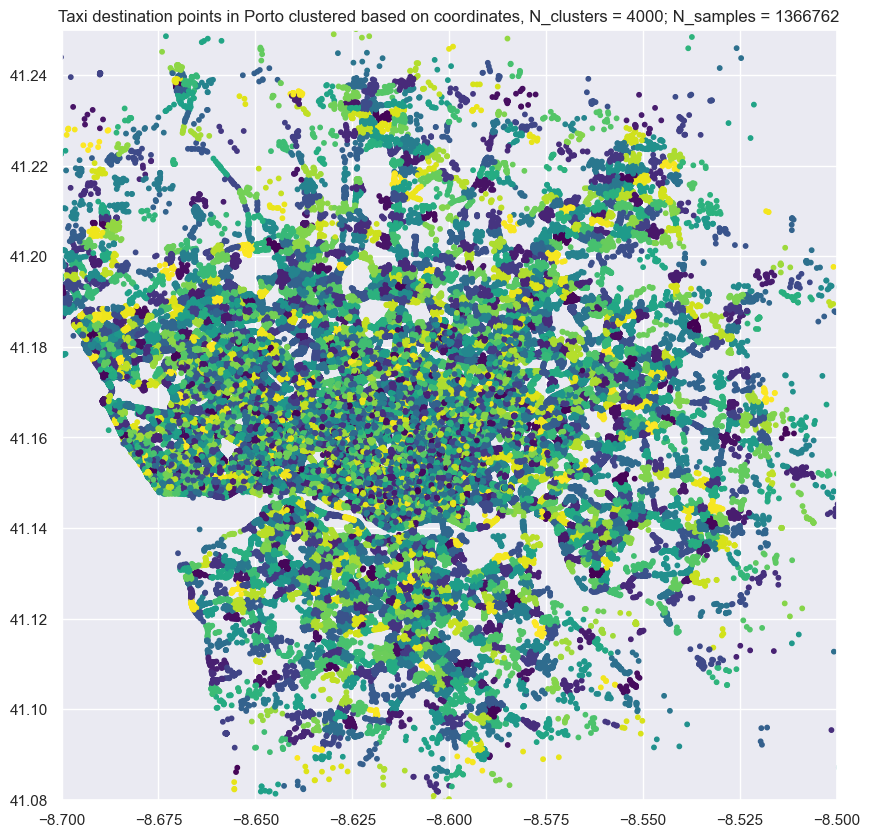

In [30]:
plt.figure(figsize=(10,10))
plt.scatter(train_data.dest_point_lon, 
                        train_data.dest_point_lat,
            c=train_data.cluster_label, s=10,cmap='viridis')
plt.ylim([41.08,41.25])
plt.xlim([-8.7,-8.5])
plt.title(f'Taxi destination points in Porto clustered based on coordinates, N_clusters = {train_data.cluster_label.max()+1}; N_samples = {train_data.shape[0]}')
plt.show()

In [40]:
train_data = convert_polyline_to_geojson_format(data=train_data, name_column='start_point')
test_data = convert_polyline_to_geojson_format(data=test_data, name_column='start_point')

In [44]:
train_data = extract_lat_lon(train_data, 'start_point')

plt.figure(figsize=(10,10))
plt.ylim([41.08,41.25])
plt.xlim([-8.7,-8.5])
for index,row in train_data.iterrows():
    route = pd.DataFrame({'LON': [row.start_point_lon,row.dest_point_lon],
                          'LAT': [row.start_point_lat,row.dest_point_lat]})
    
    
    plt.plot(route.LON,route.LAT, '-o')
    if index == 2000:
        break
plt.show()

In [47]:
train_data[['trip_id', 'cluster_label']]

,trip_id,cluster_label
0,1372636858620000589,3849
1,1372637303620000596,2992
2,1372636951620000320,1160
3,1372636854620000520,2640
4,1372637091620000337,1604
...,...,...
1366757,1404164723620000332,1481
1366758,1404171463620000698,1481
1366759,1404171367620000670,883
1366760,1404141826620000248,3100


In [49]:
grouped_data = train_data.groupby('cluster_label', as_index=False)['trip_id'].nunique()

In [51]:
frequent_dest = grouped_data.sort_values(by='trip_id', ascending=False).head(50)

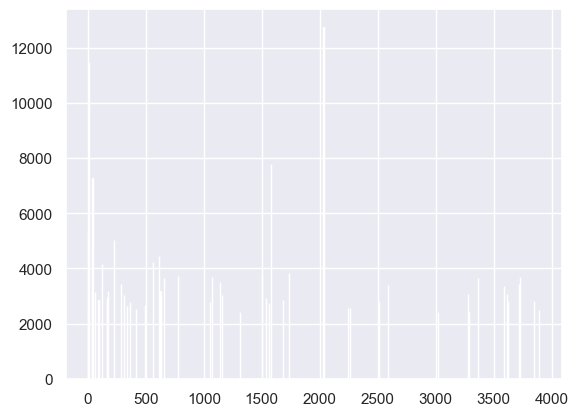

In [53]:
sns.set()
plt.bar(frequent_dest.cluster_label, frequent_dest.trip_id)
plt.show()